In [2]:
%matplotlib notebook
import gmaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as sci

from config import gkey,api_key
from census import Census
from census_vars import censuskey,censusval

def coordinates(loc):
    params = {"address": loc, "key":gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params = params)
    place_geo = response.json()
    lat = place_geo['results'][0]["geometry"]['location']['lat']
    lng = place_geo['results'][0]["geometry"]['location']['lng']
    return lat, lng

c = Census(api_key, year=2018)
gmaps.configure(api_key = gkey)

In [3]:
df = pd.read_excel("Tables/Table_13_Hate_Crime_Incidents_per_Bias_Motivation_and_Quarter_by_State_and_Agency_2018.xlsm")
df.dropna(inplace=True)
ls = []
for x in df["Agency name"]:
    if '3' in x:
        #print(x)
        ls.append(x[:-1])
    else:
        ls.append(x)
df["Agency name"] = ls

In [4]:
dfloc = pd.read_csv("locations.csv")
dfloc["Loc"] = dfloc["State"] + "," + dfloc["Agency name"]

df["Loc"] = df["State"] + "," + df["Agency name"]
dfa = pd.merge(df,dfloc,on=["Loc","Loc"])
dfa = dfa.loc[:,['Loc', 'Lat', 'Lng','Population', 'Race/Ethnicity/Ancestry',
       'Religion', 'Sexual Orientation', 'Disability', 'Gender',
       'Gender identity']]
dfa["Total"] = dfa["Race/Ethnicity/Ancestry"] + dfa["Religion"] + dfa["Gender"] + dfa["Gender identity"] + dfa["Disability"]
loc = dfa.loc[:,["Lat","Lng"]]

In [29]:
# results saved to file locations.csv, not worth re-running outside of error
df["Lat"] = ""
df["Lng"] = ""
for i,r in df.iterrows():
    st = r[2] + ',' + r[0]
    lat,lng = coordinates(st)
    df.loc[i,["Lat"]] = lat
    df.loc[i,["Lng"]] = lng
dfloc = df.loc[:,['State', 'Agency name', 'Lat', 'Lng']]

dfloc.to_csv("locations.csv")

In [6]:
dfg = df.groupby("State").sum()
dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity']]
dfg["Total"] = dfg["Race/Ethnicity/Ancestry"] + dfg["Religion"] + dfg["Gender"] + dfg["Gender identity"] + dfg["Disability"] + dfg["Sexual Orientation"]


In [55]:
plt.figure(figsize=(8,6))

race = plt.bar(range(dfg.shape[0]),dfg["Race/Ethnicity/Ancestry"])
sex  = plt.bar(range(dfg.shape[0]),dfg["Sexual Orientation"],bottom=dfg["Race/Ethnicity/Ancestry"])
rel  = plt.bar(range(dfg.shape[0]),dfg["Religion"], bottom = dfg["Race/Ethnicity/Ancestry"]+ dfg["Sexual Orientation"])
dis  = plt.bar(range(dfg.shape[0]),dfg["Disability"], bottom = dfg["Race/Ethnicity/Ancestry"] + dfg["Sexual Orientation"]+ dfg["Religion"])
gen  = plt.bar(range(dfg.shape[0]),dfg["Gender"] + dfg["Gender identity"], bottom = dfg["Race/Ethnicity/Ancestry"]+ dfg["Sexual Orientation"] + dfg["Religion"] + dfg["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crimes by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Number of Hate Crimes")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

plt.savefig("HateCrimes.png")

<IPython.core.display.Javascript object>

In [7]:
dfgp = dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
dfgp["Race/Ethnicity/Ancestry"] = dfg["Race/Ethnicity/Ancestry"]/dfg["Total"]
dfgp["Disability"] = dfg["Disability"]/dfg["Total"]
dfgp["Religion"] = dfg["Religion"]/dfg["Total"]
dfgp["Gender identity"] = dfg["Gender identity"]/dfg["Total"]
dfgp["Gender"] = dfg["Gender"]/dfg["Total"]
dfgp["Sexual Orientation"] = dfg["Sexual Orientation"]/dfg["Total"]

In [59]:
plt.figure(figsize=(8,6))
race = plt.bar(range(dfg.shape[0]),dfgp["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(dfg.shape[0]),dfgp["Sexual Orientation"],bottom=dfgp["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(dfg.shape[0]),dfgp["Religion"], bottom = dfgp["Race/Ethnicity/Ancestry"]+ dfgp["Sexual Orientation"])
dis = plt.bar(range(dfg.shape[0]),dfgp["Disability"], bottom = dfgp["Race/Ethnicity/Ancestry"] + dfgp["Sexual Orientation"]+ dfgp["Religion"])
gen = plt.bar(range(dfg.shape[0]),dfgp["Gender"] + dfgp["Gender identity"], bottom = dfgp["Race/Ethnicity/Ancestry"]+ dfgp["Sexual Orientation"] + dfgp["Religion"] + dfgp["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crime Distribution by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Ratio of Hate Crimes")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

plt.savefig("HateCrimesRelative.png")

<IPython.core.display.Javascript object>

In [8]:
dfgpop = dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
dfgpop["Race/Ethnicity/Ancestry"] = dfg["Race/Ethnicity/Ancestry"]/dfg["Population"]
dfgpop["Disability"] = dfg["Disability"]/dfg["Population"]
dfgpop["Religion"] = dfg["Religion"]/dfg["Population"]
dfgpop["Gender identity"] = dfg["Gender identity"]/dfg["Population"]
dfgpop["Gender"] = dfg["Gender"]/dfg["Population"]
dfgpop["Sexual Orientation"] = dfg["Sexual Orientation"]/dfg["Population"]
dfgpop = dfgpop.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation','Disability', 'Gender', 'Gender identity']] * 1000000


In [61]:
plt.figure(figsize=(8,6))

race = plt.bar(range(dfg.shape[0]),dfgpop["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(dfg.shape[0]),dfgpop["Sexual Orientation"],bottom=dfgpop["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(dfg.shape[0]),dfgpop["Religion"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"])
dis = plt.bar(range(dfg.shape[0]),dfgpop["Disability"], bottom = dfgpop["Race/Ethnicity/Ancestry"] + dfgpop["Sexual Orientation"]+ dfgpop["Religion"])
gen = plt.bar(range(dfg.shape[0]),dfgpop["Gender"] + dfgpop["Gender identity"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"] + dfgpop["Religion"] + dfgpop["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crimes per Capita by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Number of Hate Crimes (per million pop.)")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

plt.savefig("HateCrimesPop.png")

<IPython.core.display.Javascript object>

In [9]:
dfgpop["Total"] = dfgpop.sum(axis=1)

for x in dfgpop.columns:
    dfgpop[x] = dfgpop[x]/dfgpop["Total"]

<IPython.core.display.Javascript object>


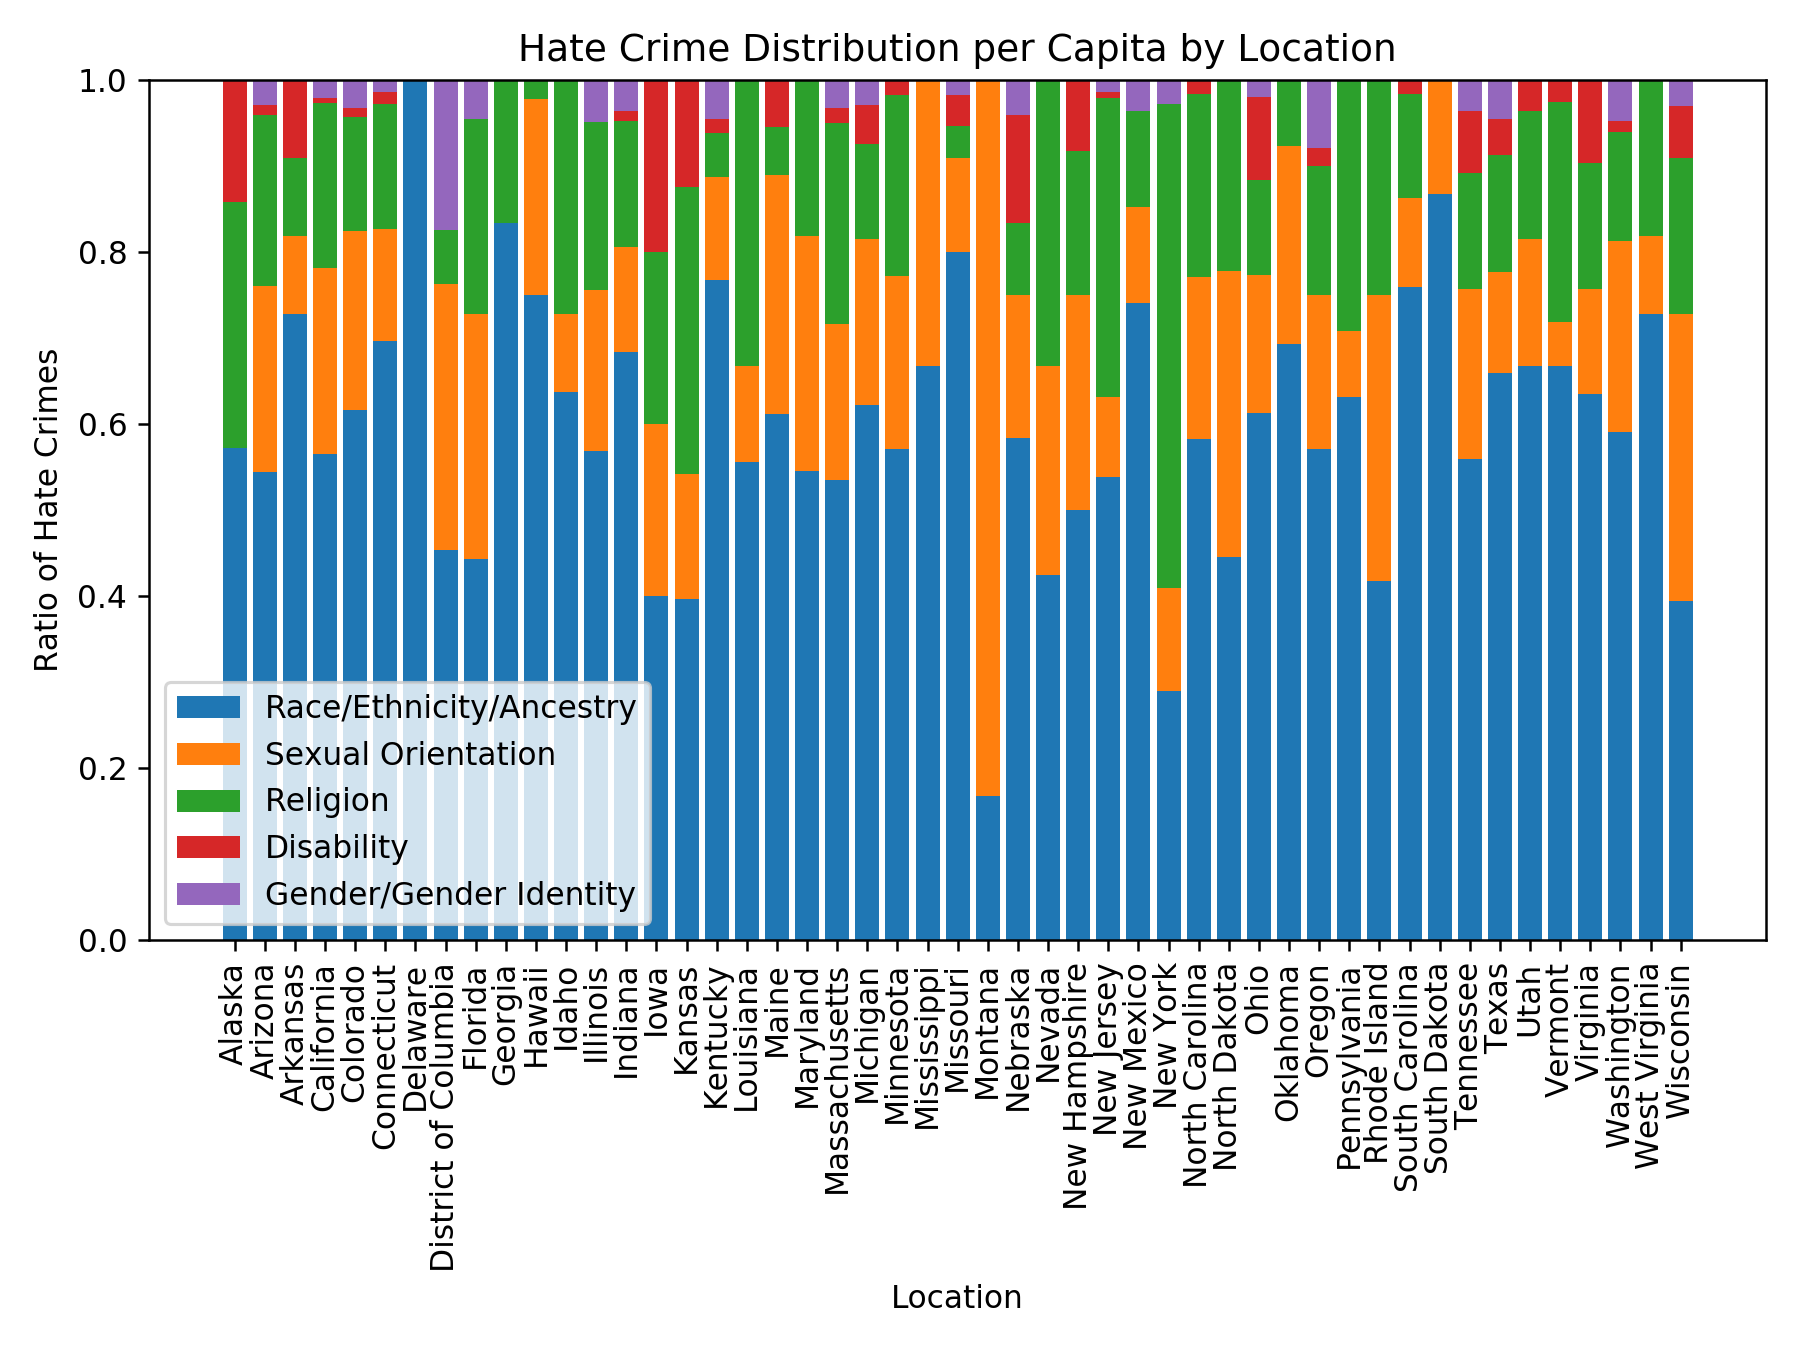

In [62]:
plt.figure(figsize=(8,6))
    
race = plt.bar(range(dfg.shape[0]),dfgpop["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(dfg.shape[0]),dfgpop["Sexual Orientation"],bottom=dfgpop["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(dfg.shape[0]),dfgpop["Religion"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"])
dis = plt.bar(range(dfg.shape[0]),dfgpop["Disability"], bottom = dfgpop["Race/Ethnicity/Ancestry"] + dfgpop["Sexual Orientation"]+ dfgpop["Religion"])
gen = plt.bar(range(dfg.shape[0]),dfgpop["Gender"] + dfgpop["Gender identity"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"] + dfgpop["Religion"] + dfgpop["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crime Distribution per Capita by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Ratio of Hate Crimes")
plt.xlabel("Location")
plt.tight_layout()
plt.show()

plt.savefig("HateCrimePopRelative.png")

In [21]:
f = gmaps.figure()
l = gmaps.symbol_layer(loc,scale=2)
f.add_layer(l)
f

Figure(layout=FigureLayout(height='420px'))

In [12]:
cd = c.acs.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E", "B23025_005E","B16001_002E"), {'for': 'state:*'})
dfcd = pd.DataFrame(cd)
cols = list(dfcd.columns)
i = 0
for co in cols:
    if co == "NAME":
        cols[i] = "State"
    if co in censusval:
        cols[i] = censusval[co]
    i = i + 1
dfcd.columns = cols
del dfcd["state"]
dfcd.head()

State   income  population   age  income_per_capita   poverty  \
0    Minnesota  68411.0   5527358.0  37.9            36245.0  547442.0   
1  Mississippi  43567.0   2988762.0  37.2            23434.0  599795.0   
2     Missouri  53560.0   6090062.0  38.5            29537.0  837930.0   
3      Montana  52559.0   1041732.0  39.8            29765.0  139063.0   
4     Nebraska  59116.0   1904760.0  36.4            31101.0  213790.0   

   employment_unemployed  language_speak_only_english  
0               119218.0                    4571735.0  
1               110036.0                    2691455.0  
2               155958.0                    5367705.0  
3                22433.0                     939716.0  
4                36545.0                    1574067.0

In [43]:
dfrace = pd.merge(dfg,dfcd, how="left",on=["State","State"])
dfrace["PercentEnglish"] = dfrace.language_speak_only_english / dfrace.population
dfrace.head()

State  Race/Ethnicity/Ancestry  Religion  Sexual Orientation  \
0      Alaska                        4         2                   0   
1     Arizona                       93        34                  37   
2    Arkansas                        8         1                   1   
3  California                      544       185                 208   
4    Colorado                       56        12                  19   

   Disability  Gender  Gender identity  1st quarter  3rd quarter  4th quarter  \
0           1       0                0          1.0          4.0          0.0   
1           2       2                3         51.0         35.0         36.0   
2           1       0                0          4.0          1.0          2.0   
3           5       4               17        212.0        265.0        228.0   
4           1       0                3         15.0         21.0         19.0   

   Population  Total   income  population   age  income_per_capita    poverty  \
0    358822.0      7  76715.0    738516.0  34.0            35874.0    77865.0   
1   4275253.0    171  56213.0   6946685.0  37.4            29265.0  1092192.0   
2    342312.0     11  45726.0   2990671.0  37.9            25635.0   510337.0   
3  24792513.0    963  71228.0  39148760.0  36.3            35021.0  5487141.0   
4   2398112.0     91  68811.0   5531141.0  36.6            36415.0   590504.0   

   employment_unemployed  language_speak_only_english  PercentEnglish  
0                28067.0                     573373.0        0.776385  
1               210214.0                    4740041.0        0.682346  
2                75774.0                    2593351.0        0.867147  
3              1321502.0                   20487071.0        0.523313  
4               139326.0                    4314327.0        0.780007

<IPython.core.display.Javascript object>


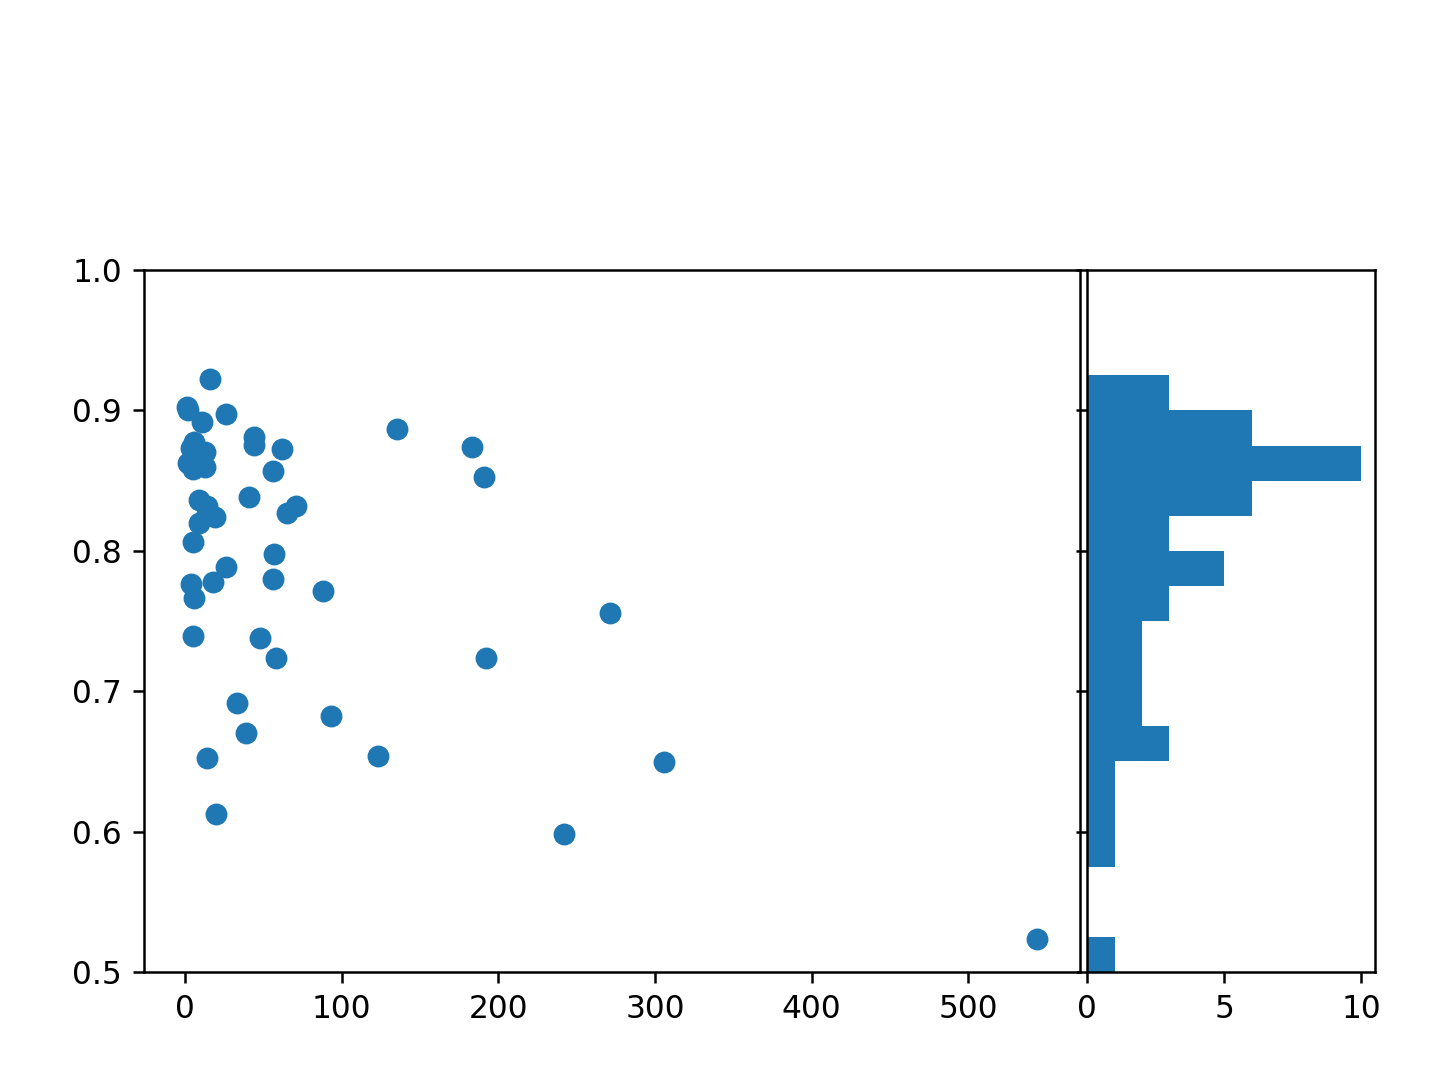

In [26]:
x = dfrace["Race/Ethnicity/Ancestry"]
y = dfrace["PercentEnglish"]

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.025
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    #ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure()

ax = fig.add_axes(rect_scatter)
#ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)
plt.ylim(0.5,1)

plt.title("Racial/Ethnic/Ancestry-based Hate Crimes and the Ratio of English-only Speakers")
plt.xlabel("Number of Hate Crimes")
plt.ylabel("Ratio of English-only speakers in a population")
plt.show()

In [35]:
sci.pearsonr(dfrace["Race/Ethnicity/Ancestry"],dfrace["PercentEnglish"])

(-0.5474155325921943, 4.6904447245066614e-05)

In [41]:
dfrace = pd.merge(dfg,dfcd, how="left",on=["State","State"])

dfrace["PercentEnglish"] = dfrace.language_speak_only_english / dfrace.population

plt.scatter(dfrace["Religion"],dfrace["PercentEnglish"])

<IPython.core.display.Javascript object>

In [38]:
sci.pearsonr(dfrace["Religion"],dfrace["PercentEnglish"])

(-0.5766945328172296, 1.4446413510251614e-05)

<IPython.core.display.Javascript object>


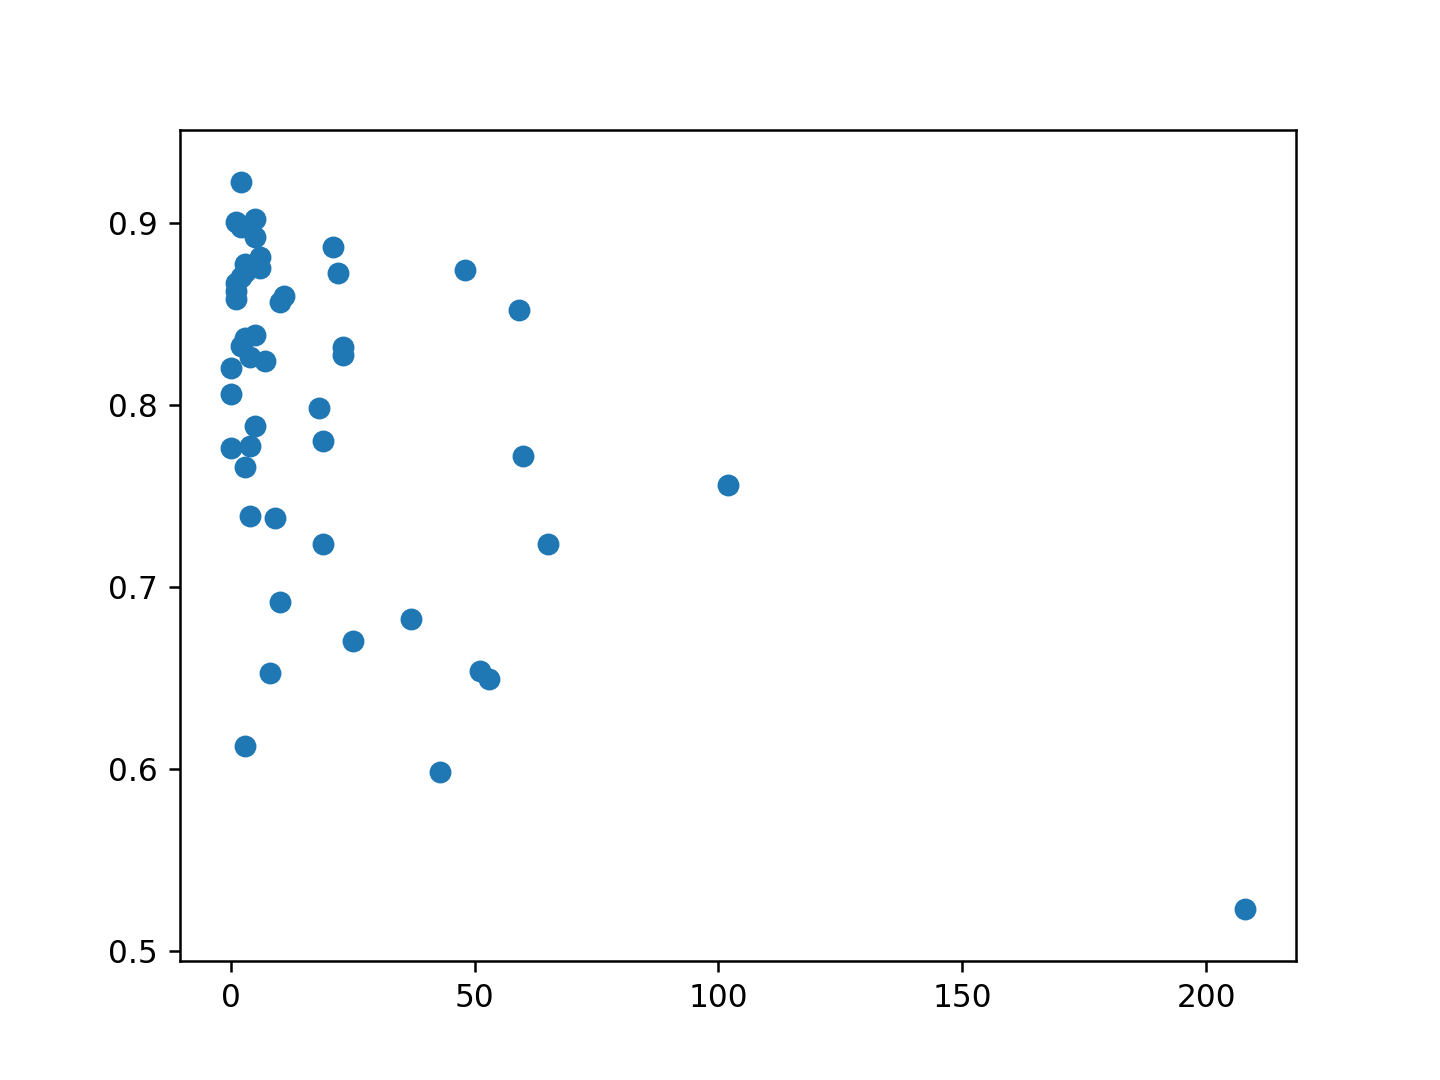

In [42]:
plt.scatter(dfrace["Sexual Orientation"],dfrace["PercentEnglish"])

In [44]:
sci.pearsonr(dfrace["Sexual Orientation"],dfrace["PercentEnglish"])

(-0.5466954394263093, 4.821656664722198e-05)

<IPython.core.display.Javascript object>


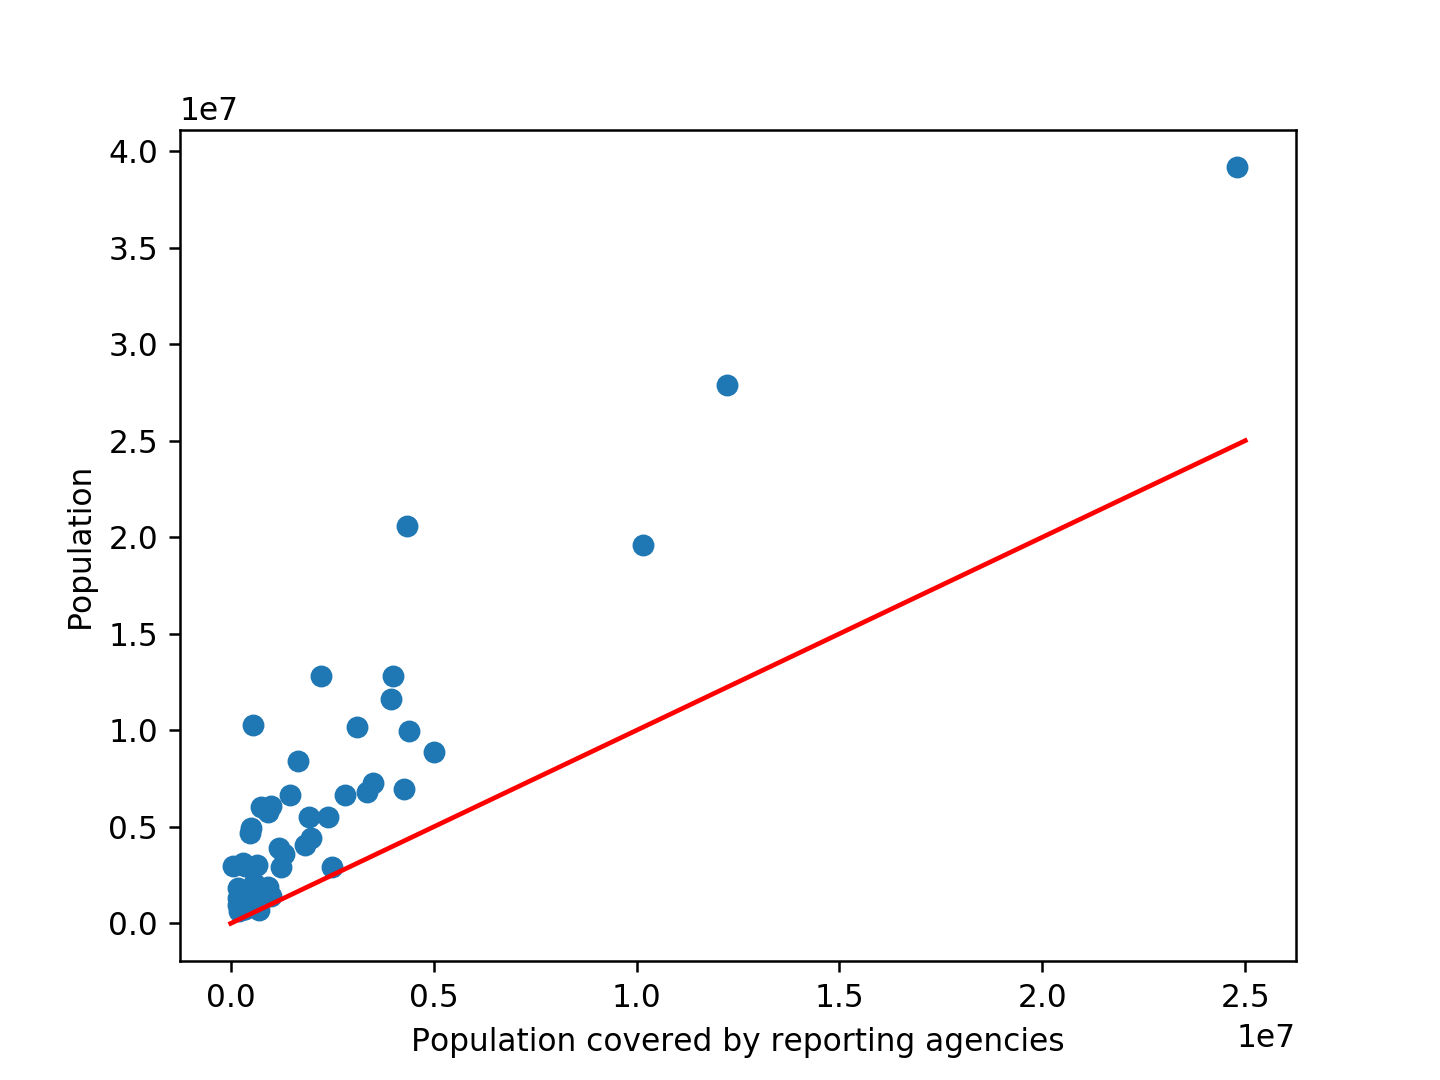

Text(0, 0.5, 'Population')

In [31]:
plt.scatter(dfrace["Population"],dfrace["population"])
plt.plot([0,25000000],[0,25000000],c='r')

plt.xlabel("Population covered by reporting agencies")
plt.ylabel("Population")

<IPython.core.display.Javascript object>


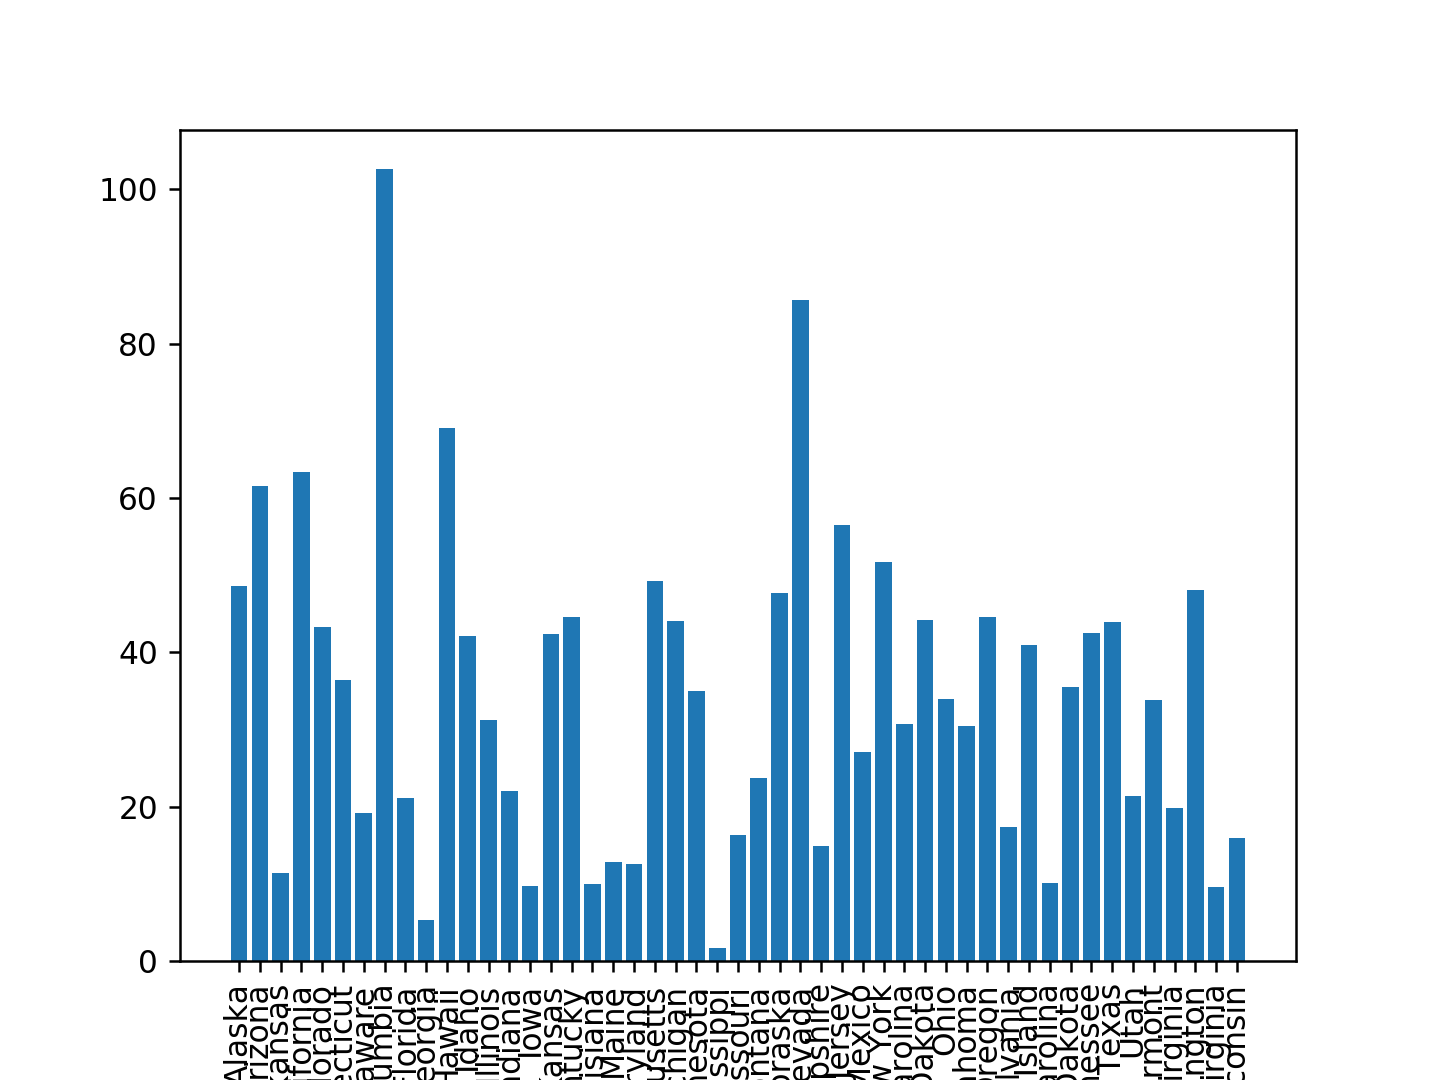

In [50]:
dfrace["PerPop"] = dfrace["Population"]/dfrace["population"]*100

plt.bar(range(dfrace.shape[0]),dfrace["PerPop"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.show()

In [52]:
dfrace[["State","PerPop"]].sort_values("PerPop").to_csv("PercentPopulation.csv")